In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

## First Scan

In [40]:
fname = "2020_10_30.hdf"
dset_name = "1604079662 find R0 F1"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [41]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [42]:
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['Laser Lock']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

In [9]:
ch = 1
integrals_unsorted = [-np.trapz(pxie[idx][0:2000, ch]-np.mean(pxie[idx][0:250, ch])) for idx in range(1, max(pxie_time.keys())+1)]

In [10]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()
integrals, freqs = combine_arrays_irregular(sorted_pxie_indices-1, integrals_unsorted, 
                                            [idx_pairs[idx] for idx in sorted_pxie_indices], data_devices['Laser Lock']['laser 2 frequency'])
integrals, freqs = np.array(integrals), np.array(freqs)

In [11]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()
integrals, freqs = combine_arrays_irregular(sorted_pxie_indices-1, integrals_unsorted, 
                                            [idx_pairs[idx] for idx in sorted_pxie_indices], data_devices['Laser Lock']['laser 2 frequency'])
integrals, freqs = np.array(integrals), np.array(freqs)

In [13]:
inv_idx_pairs = {v: k for k, v in idx_pairs.items()}

bins = np.arange(int(freqs.min()), int(freqs.max()), 1.5)
indices_binned = np.digitize(data_devices['Laser Lock']['laser 2 frequency'][list(idx_pairs.values())], bins)
binned_traces = {b:[] for b in (bins+np.diff(bins)[0]/2)}
for idx_bin, idx_laserlock in zip(indices_binned, idx_pairs.values()):
    idx_pxie = inv_idx_pairs[idx_laserlock]
    trace = pxie[idx_pxie][:,ch].astype(float)
    trace -= np.mean(np.append(trace[:250], trace[-100:]))
    if idx_bin < len(bins):
        binned_traces[bins[idx_bin]+np.diff(bins)[0]/2].append(-trace)
        
for key, val in binned_traces.items():
    binned_traces[key] = np.asarray(val)

In [14]:
averages_binned_traces = {}
for key, val in binned_traces.items():
    averages_binned_traces[key] = np.mean(val, axis = 0)
    
integrated_binned_traces = {}
for key, val in averages_binned_traces.items():
    integrated_binned_traces[key] = np.trapz(val)
    
interrors_binned_traces = {}
for key, val in binned_traces.items():
    interrors_binned_traces[key] = np.sum(np.std(val, axis = 0))/np.sqrt(len(val))

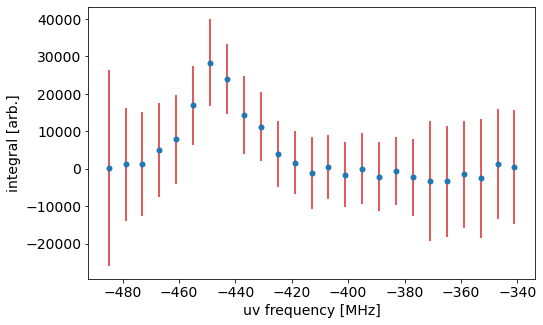

In [15]:
f = 4*np.array(list(integrated_binned_traces.keys()))
i = list(integrated_binned_traces.values())
e = list(interrors_binned_traces.values())


fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(f, i, e, fmt = '.', ecolor = 'C3', ms = 10)
ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

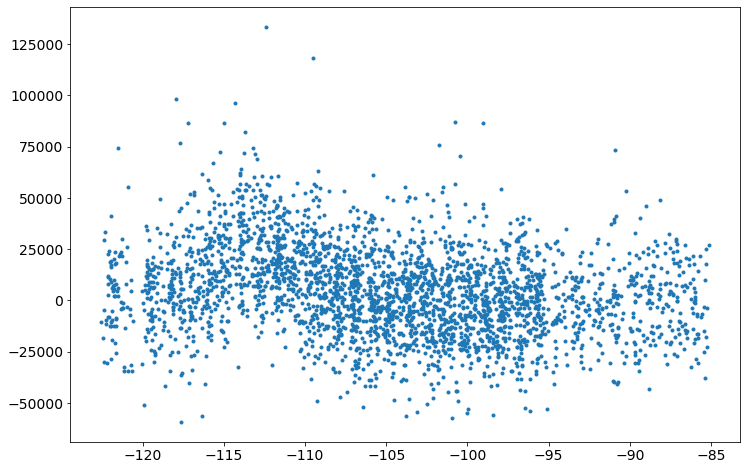

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(freqs, integrals, '.')
set_fontsize(ax, 14)

In [17]:
from scipy import stats
means, bin_edges, _ = stats.binned_statistic(freqs, integrals, 'mean', bins = bins)

err_calc_fun = lambda x: np.std(x)/np.sqrt(len(x))
stds, _, _ = stats.binned_statistic(freqs, integrals, err_calc_fun, bins = bins)

bin_centers = bin_edges[:-1]+np.diff(bin_edges)[0]/2

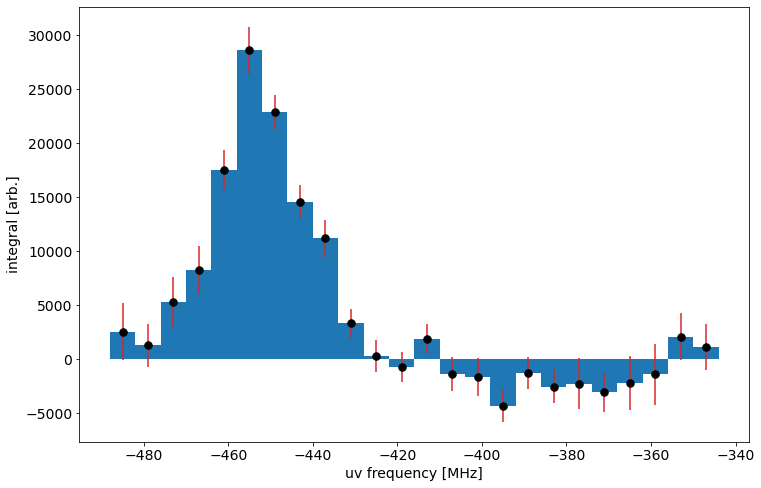

In [18]:
fig, ax = plt.subplots(figsize = (12,8))
ax.bar(bin_edges[:-1]*4, means, width = np.diff(bin_centers)[0]*4, align = 'edge')
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'k', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

In [19]:
from astropy import constants
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from astropy.modeling import functional_models

In [20]:
def lorentzian(x, μ, fwhm):
    y = (x-μ)/(fwhm/2)
    return 1/(1+y**2)

def voight(x,a,μ,fwhm_L,fwhm_G):
    return functional_models.Voigt1D(μ,a,fwhm_L,fwhm_G)(x)

[ 2.93089933e+04 -4.53197806e+02  1.79837515e+01]


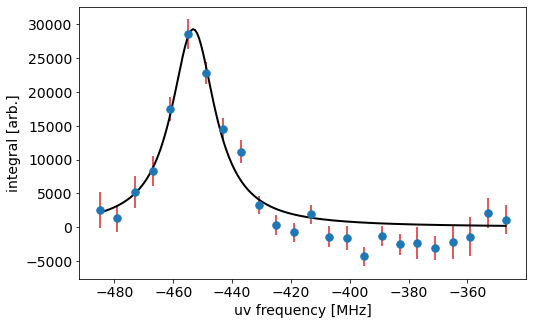

In [21]:
_f = np.linspace(bin_centers.min(), bin_centers.max(), 201)

fit_fun = lambda x,a,μ,fwhm: a*lorentzian(x,μ,fwhm)

popt, pcov = curve_fit(fit_fun, bin_centers*4, means, sigma = stds, p0 = [25000,-450, 15])
print(popt)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, fit_fun(_f*4, *popt), 'k', lw = 2)
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'C0', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

[ 4.98625348e+08 -4.52709009e+02  8.53242743e-04  2.50424389e+01]


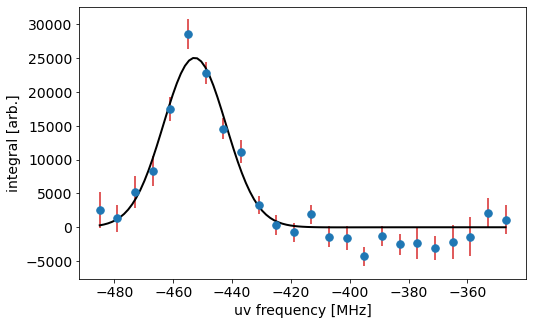

In [22]:
_f = np.linspace(bin_centers.min(), bin_centers.max(), 101)

popt, pcov = curve_fit(voight, bin_centers*4, means, sigma = stds, p0 = [29e4,-453, 18,10], maxfev = 5000)
print(popt)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, voight(_f*4, *popt), 'k', lw = 2)
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'C0', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

## Changed Alignment Detection Slightly, different angle and better centered

In [24]:
fname = "2020_10_30.hdf"
dset_name = "1604083497 find R0 F1"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [25]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [26]:
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['Laser Lock']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

In [27]:
ch = 1
integrals_unsorted = [-np.trapz(pxie[idx][0:2000, ch]-np.mean(pxie[idx][0:250, ch])) for idx in range(1, max(pxie_time.keys())+1)]

In [28]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()
integrals, freqs = combine_arrays_irregular(sorted_pxie_indices-1, integrals_unsorted, 
                                            [idx_pairs[idx] for idx in sorted_pxie_indices], data_devices['Laser Lock']['laser 2 frequency'])
integrals, freqs = np.array(integrals), np.array(freqs)

In [29]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()
integrals, freqs = combine_arrays_irregular(sorted_pxie_indices-1, integrals_unsorted, 
                                            [idx_pairs[idx] for idx in sorted_pxie_indices], data_devices['Laser Lock']['laser 2 frequency'])
integrals, freqs = np.array(integrals), np.array(freqs)

In [30]:
inv_idx_pairs = {v: k for k, v in idx_pairs.items()}

bins = np.arange(int(freqs.min()), int(freqs.max()), 1.5)
indices_binned = np.digitize(data_devices['Laser Lock']['laser 2 frequency'][list(idx_pairs.values())], bins)
binned_traces = {b:[] for b in (bins+np.diff(bins)[0]/2)}
for idx_bin, idx_laserlock in zip(indices_binned, idx_pairs.values()):
    idx_pxie = inv_idx_pairs[idx_laserlock]
    trace = pxie[idx_pxie][:,ch].astype(float)
    trace -= np.mean(np.append(trace[:250], trace[-100:]))
    if idx_bin < len(bins):
        binned_traces[bins[idx_bin]+np.diff(bins)[0]/2].append(-trace)
        
for key, val in binned_traces.items():
    binned_traces[key] = np.asarray(val)

In [31]:
averages_binned_traces = {}
for key, val in binned_traces.items():
    averages_binned_traces[key] = np.mean(val, axis = 0)
    
integrated_binned_traces = {}
for key, val in averages_binned_traces.items():
    integrated_binned_traces[key] = np.trapz(val)
    
interrors_binned_traces = {}
for key, val in binned_traces.items():
    interrors_binned_traces[key] = np.sum(np.std(val, axis = 0))/np.sqrt(len(val))

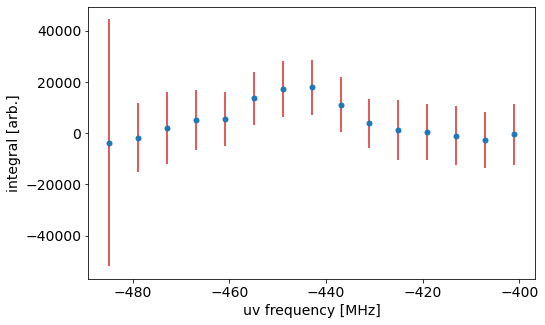

In [32]:
f = 4*np.array(list(integrated_binned_traces.keys()))
i = list(integrated_binned_traces.values())
e = list(interrors_binned_traces.values())


fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(f, i, e, fmt = '.', ecolor = 'C3', ms = 10)
ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

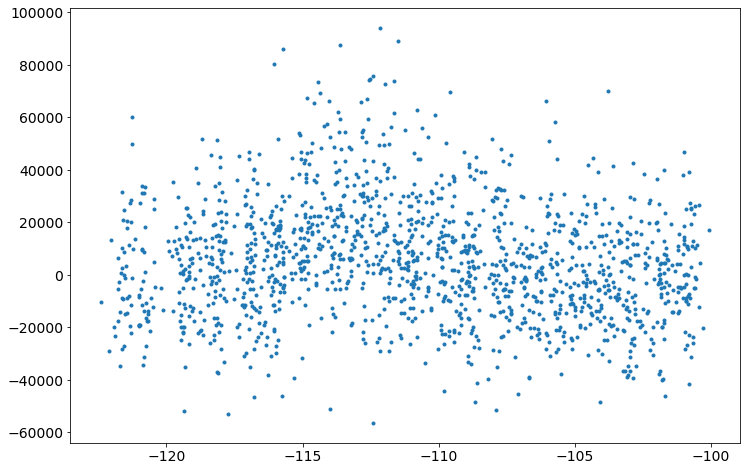

In [33]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(freqs, integrals, '.')
set_fontsize(ax, 14)

In [34]:
from scipy import stats
means, bin_edges, _ = stats.binned_statistic(freqs, integrals, 'mean', bins = bins)

err_calc_fun = lambda x: np.std(x)/np.sqrt(len(x))
stds, _, _ = stats.binned_statistic(freqs, integrals, err_calc_fun, bins = bins)

bin_centers = bin_edges[:-1]+np.diff(bin_edges)[0]/2

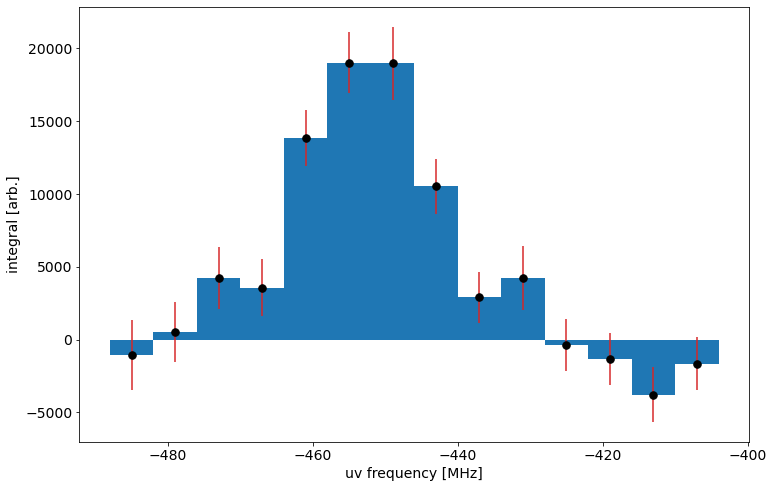

In [35]:
fig, ax = plt.subplots(figsize = (12,8))
ax.bar(bin_edges[:-1]*4, means, width = np.diff(bin_centers)[0]*4, align = 'edge')
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'k', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

In [36]:
from astropy import constants
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from astropy.modeling import functional_models

In [37]:
def lorentzian(x, μ, fwhm):
    y = (x-μ)/(fwhm/2)
    return 1/(1+y**2)

def voight(x,a,μ,fwhm_L,fwhm_G):
    return functional_models.Voigt1D(μ,a,fwhm_L,fwhm_G)(x)

[ 2.21307616e+04 -4.52796014e+02  1.60556370e+01]


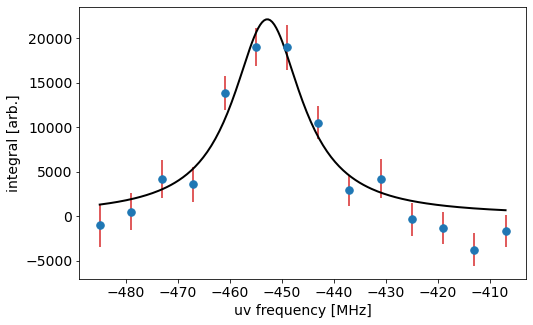

In [38]:
_f = np.linspace(bin_centers.min(), bin_centers.max(), 201)

fit_fun = lambda x,a,μ,fwhm: a*lorentzian(x,μ,fwhm)

popt, pcov = curve_fit(fit_fun, bin_centers*4, means, sigma = stds, p0 = [25000,-450, 15])
print(popt)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, fit_fun(_f*4, *popt), 'k', lw = 2)
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'C0', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

[ 1.61015228e+08 -4.52862073e+02  1.73700834e-03  2.04590261e+01]


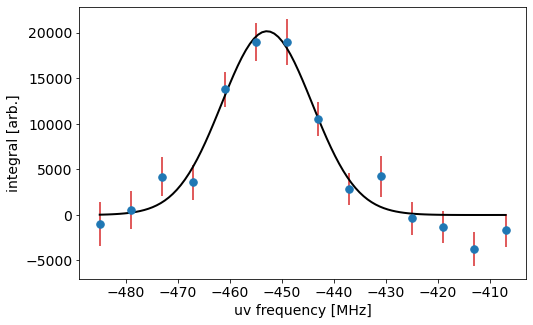

In [39]:
_f = np.linspace(bin_centers.min(), bin_centers.max(), 101)

popt, pcov = curve_fit(voight, bin_centers*4, means, sigma = stds, p0 = [29e4,-453, 18,10], maxfev = 5000)
print(popt)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, voight(_f*4, *popt), 'k', lw = 2)
ax.errorbar(bin_centers*4, means, stds, fmt = '.', color = 'C0', ecolor = 'C3', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)